In [287]:
import math
import re

from nltk.tokenize import TweetTokenizer, word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from typing import Callable, Iterable

In [288]:
LEARNING_RATE = 0.004
BATCH_SIZE = 64
EPOCHS = 200
NUM_CLASSES = 3

In [289]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"
EMBEDDINGS_PATH = './glove.6B.50d.txt'

In [290]:
wordVectors: "dict[str, np.ndarray]" = {}
lineElements: "list[str]" = []
with open(EMBEDDINGS_PATH) as file:
    for line in file:
        lineElements = line.replace('\n', '').split()
        word = lineElements.pop(0)
        wordVector = np.array([float(w) for w in lineElements])
        wordVectors[word] = wordVector
dimensions = len(lineElements)

In [291]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [292]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [293]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = np.array([ar[0] for ar in features.values])
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = np.array([ar[0] for ar in features.values])
validLabels = validDF['label'].values

In [294]:
def customPreprocessor(text: str):    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+|#', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

In [295]:
tokenizer = TweetTokenizer()
def vectorizeTweet(tweet: str, preprocessor: Callable[[str], str], wordVectors: "dict[str, np.ndarray]", dimensions: int) -> np.ndarray:
    # words = preprocessor(tweet).split()
    words = tokenizer.tokenize(preprocessor(tweet))
    # words = tokenizer.tokenize(tweet)
    vector: np.ndarray = np.zeros(dimensions)
    for word in words:
        wordVector = wordVectors.get(word)
        if wordVector is not None:
            vector += wordVector        
    return vector / len(words)

In [296]:
trainSet_X: np.ndarray = np.zeros(shape=(len(X_train), dimensions))
for i, sample in enumerate(X_train):
    trainSet_X[i] = vectorizeTweet(sample, customPreprocessor, wordVectors, dimensions)

validSet_X: np.ndarray = np.zeros(shape=(len(X_valid), dimensions))
for i, sample in enumerate(X_valid):
    validSet_X[i] = vectorizeTweet(sample, customPreprocessor, wordVectors, dimensions)


In [297]:
class Network(nn.Module):
    def __init__(self, n_features: int, hidden_sizes: Iterable[int], n_classes: int) -> None:
        super(Network, self).__init__()
        
        self.layers = nn.ModuleList()
        n_in = n_features
        for size in hidden_sizes:
            self.layers.append(nn.Linear(n_in, size))
            self.layers.append(nn.ReLU())
            n_in = size
        self.layers.append(nn.Linear(n_in, n_classes))
    
    def forward(self, input):
        last_out = input
        for layer in self.layers:
            last_out = layer(last_out)
        return last_out


In [298]:
network = Network(dimensions, [64, 32, 16], NUM_CLASSES)
network.layers

ModuleList(
  (0): Linear(in_features=50, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=3, bias=True)
)

In [299]:
def createClassWeights(sampleLabels, numClasses):
    classCounts = [0 for _ in range(numClasses)]
    for label in sampleLabels:
        classCounts[label] += 1

    weights = []
    for count in classCounts:
        weights.append(len(sampleLabels)/count)
    
    return weights

In [300]:
def plotConfusionMatrix(trueLabels: Iterable[int], predictions:Iterable[int], title: str, displayLabels: Iterable[str]=None, axes: plt.Axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    disp = ConfusionMatrixDisplay.from_predictions(trueLabels, predictions, cmap=plt.cm.Reds, ax=axes, colorbar=False)
    if displayLabels is not None:
        disp.ax_.set_xticklabels(displayLabels)
        disp.ax_.set_yticklabels(displayLabels)
    axes.set_xlabel('Classifier predicted labels', fontsize=11)
    axes.set_ylabel('True labels', fontsize=11)
    axes.set_title(title, fontsize=14)

In [301]:
y = torch.tensor(trainLabels, dtype=torch.float)
x = torch.tensor(trainSet_X, dtype=torch.float)

dataset = TensorDataset(x, y)
trainSetLoader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

y = torch.tensor(validLabels, dtype=torch.float)
x = torch.tensor(validSet_X, dtype=torch.float)

weights = createClassWeights(trainLabels, NUM_CLASSES)
sampler = WeightedRandomSampler(weights, len(trainLabels))
dataset = TensorDataset(x, y)
validSetLoader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=None)

lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=LEARNING_RATE)

In [302]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# network.to(device)

In [303]:
def getPredictedLabels(predictions):
    softmaxLayerOut = torch.log_softmax(predictions, dim = 1)
    _, labels = torch.max(softmaxLayerOut, dim = 1)
    return labels.detach().numpy()

In [304]:
def calculateAccuracy(y_pred, y_true):
    softmaxLayerOut = torch.log_softmax(y_pred, dim = 1)
    _, predictions = torch.max(softmaxLayerOut, dim = 1)
    #_, predictions = torch.max(y_pred, dim = 1)
    
    correct = 0
    for pred, true in zip(predictions, y_true):
        correct += int(pred == true)
    
    return correct/len(y_true)*100

In [305]:
# x = x.to(device)

for epoch in range(EPOCHS):
    network.train()
    batchLosses = []
    batchAccs = []

    for batchSamples, batchLabels in trainSetLoader:
        # batchSamples = batchSamples.to(device)
        # batchLabels = batchLabels.to(device)
        predictions = network(batchSamples)

        batchLoss = lossFunction(predictions, batchLabels.long())
        batchLosses.append(batchLoss.item())

        batchAccs.append(calculateAccuracy(predictions, batchLabels))        

        optimizer.zero_grad()

        batchLoss.backward()

        optimizer.step()
    
    network.eval()
    pred = network(x)
    acc = calculateAccuracy(pred, y)
    
    print(f"Epoch {epoch:3} Train Acc = {sum(batchAccs)/len(batchAccs):.5f} Valid Acc = {acc:.5f}\r", end='')
print()

Epoch 199 Train Acc = 66.10000 Valid Acc = 64.46100


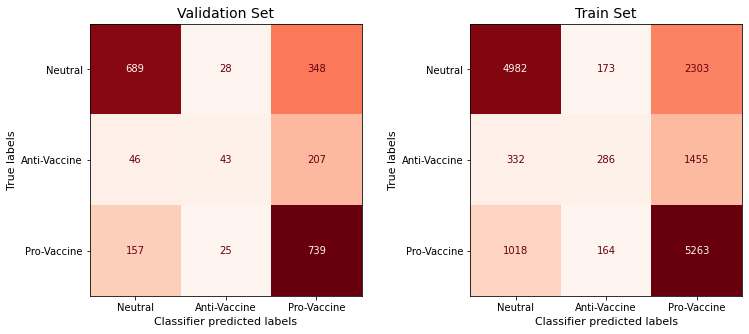

In [306]:
labels = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']
_, ax = plt.subplots(1, 2, figsize=(12.5,5))
plotConfusionMatrix(y.int().detach().numpy(), getPredictedLabels(pred), 'Validation Set', labels, ax[0])
x = torch.tensor(trainSet_X, dtype=torch.float)
pred = network(x)
plotConfusionMatrix(trainLabels, getPredictedLabels(pred), 'Train Set', labels, ax[1])